In [1]:
##Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [2]:


# Load features and labels
X = np.load('../data/features_combined.npy')
y = pd.read_csv('../data/labels.csv').values.ravel()  # flatten to 1D array

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Meta-model for stacking
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=meta_model,
    cv=5,  # 5-fold cross-validation for blending
    n_jobs=-1,
    passthrough=False  # set True if you want to include original features in meta-model
)

# Train stacking model
stacking_clf.fit(X_train, y_train)

# Make sure to get predicted probabilities for the positive class
stacking_probs = stacking_clf.predict_proba(X_test)[:, 1]

# Predict and evaluate
stack_preds = stacking_clf.predict(X_test)


# Calculate metrics
accuracy = accuracy_score(y_test, stack_preds)
roc_auc = roc_auc_score(y_test, stacking_probs)
pr_auc = average_precision_score(y_test, stacking_probs)
report = classification_report(y_test, stack_preds)

print("📊 Stacking Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:\n", report)



# Save stacking model and preprocessing objects for later use
joblib.dump(stacking_clf, "../models/stacking_model.pkl")
joblib.dump(imputer, "../models/imputer.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


📊 Stacking Model Evaluation:
Accuracy: 0.8294
ROC AUC: 0.9120
PR AUC: 0.9131

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      3281
           1       0.84      0.81      0.83      3361

    accuracy                           0.83      6642
   macro avg       0.83      0.83      0.83      6642
weighted avg       0.83      0.83      0.83      6642



['../models/scaler.pkl']

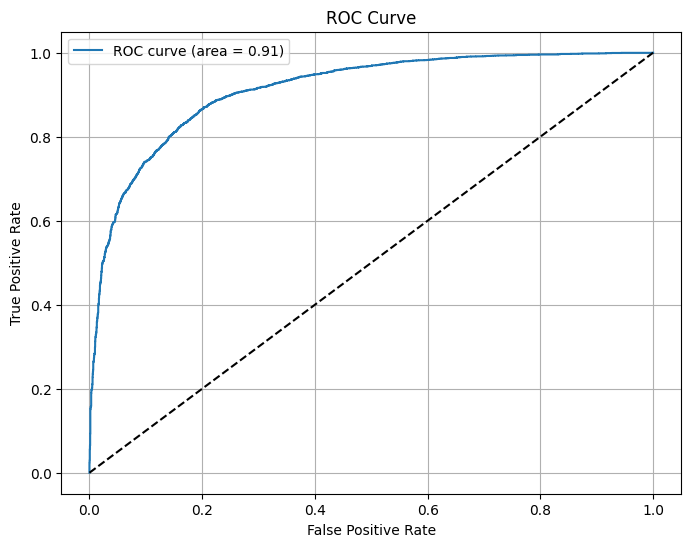

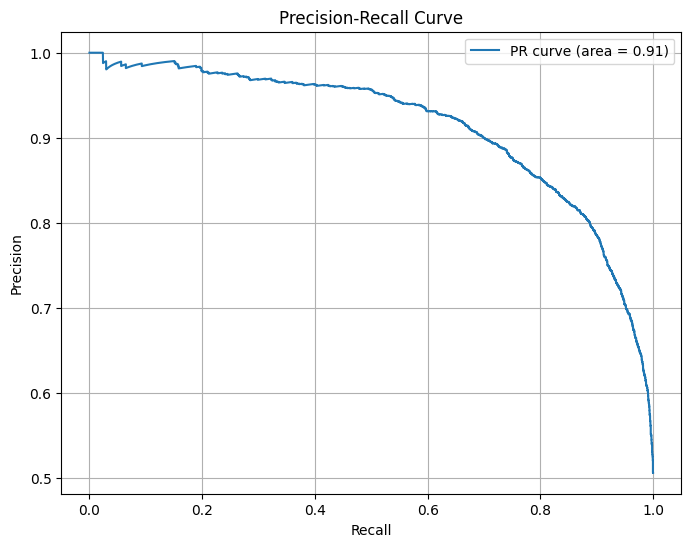

In [3]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, stacking_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, stacking_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()